# PIP MINER : PARAMETER SENSITIVITY

The purpose for theis research is to determine the parameter sensitivity for the pip miner model.

GOALS:
- Determine the range of parameters where the results are stable


In [1]:
# Import Necessary Libraries, Define the parameters
import logging
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import quantstats as qt
import seaborn as sns
from ipywidgets import Dropdown, interact, widgets
from quantminer import Miner
from scipy import stats

from scipy.ndimage import convolve, generic_filter
from IPython.display import display

# logger = logging.getLogger('optuna')
# logger.setLevel(logging.WARNING)

data_dir = Path.cwd().parent / 'data'


## STEP 0 : DATA PREPARATION AND MODELS TRAINING
- Asset : EURUSD, 1-hour
- Parameter
  - n_pivots
  - n_clusters
  - n_lookback
  - hold_period

In [2]:
# Read Price Data
data_path = data_dir / 'eur_h1.parquet'
raw_data = pd.read_parquet(data_path)

# Clean the data
data = raw_data.copy()
data = data.dropna()

# Feature Engineering
data['returns'] = data['close'].diff().fillna(0)
data['returns+1'] = data['returns'].shift(-1)

# Prepare the training data
train_daterange_start = 2010
train_daterange_end = 2021

train_data = data[(data.index.year >= train_daterange_start) & (data.index.year <= train_daterange_end)]['close']
train_data = np.array(train_data)

In [3]:
# # Functions for Optuna Parameter Sensitivity test
# import optuna


# def run_strategy(n_pivots, n_clusters, n_lookback, hold_period):

#     data = np.array(train_data)

#     # Initialize the model
#     miner = Miner(
#         n_lookback=n_lookback,
#         n_pivots=n_pivots,
#         hold_period=hold_period,
#         n_clusters = n_clusters,
#     )
    
#     # Fit the model
#     return miner.fit(data)


# def objective(trial):
#     n_pivots = trial.suggest_int('n_pivots', 3, 4)
#     n_clusters = trial.suggest_int('n_clusters', 15, 16)
#     n_lookback = trial.suggest_int('n_lookback', 8, 21)
#     hold_period = trial.suggest_int('hold_period', 1, 8)
    
#     UPI = run_strategy(n_pivots, n_clusters, n_lookback, hold_period) # Ulcer Performance Index
#     return UPI 

# # Setup and run the optimization
# def optimize_trading_params():
#     study = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler())
#     study.optimize(objective, n_trials=2)
    
#     print("Best parameters: ", study.best_params)
#     print("Best value (metric): ", study.best_value)

#     return study

# def optimize_trading_params():
#     search_space = {
#         'n_pivots': [3, 4],
#         'n_clusters': [16, 15],
#         'n_lookback': [int(x) for x in np.arange(8, 22)],
#         'hold_period': [int(x) for x in np.arange(1, 9)]
#     }
#     sampler = optuna.samplers.GridSampler(search_space)
#     study = optuna.create_study(direction='maximize', sampler=sampler)
#     study.optimize(objective, n_jobs=-1)  # Total combinations of parameters

#     print("Best parameters: ", study.best_params)
#     print("Best value (metric): ", study.best_value)
#     return study


# def compile_results(study):
#     results = []
#     for trial in study.trials:
#         params:dict = trial.params
#         params.update(
#             martin=trial.value,
#             state=trial.state
#         )

#         results.append(params)

#     results_df = pd.DataFrame(results)
#     results_df.to_parquet()
#     return results_df

# # Execute the optimization
# study = optimize_trading_params()

In [4]:
# Functions for Plotting Distribution
def get_distribution(data, title):

    data = np.abs(data)

    mean = np.mean(data)
    std = np.std(data)
    median = np.median(data)
    
    print("Mean : ", mean)
    print("Standard Deviation : ", std)
    
   # Adjust the plot size
    plt.figure(figsize=(4, 3))  # You can adjust the figsize values as per your needs
    
    # Plot the distribution
    plt.hist(data, bins=30, color='lightblue', edgecolor='black') 

    # Add vertical lines for mean and median
    plt.axvline(x=mean, color='blue', linestyle='--', label='Mean')
    plt.axvline(x=median, color='red', linestyle='--', label='Median')

    # Customization
    plt.title(f"Distribution of {title}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()  # Show the labels

    plt.show()

    plt.show()


def plot_xy_hist(data, col_x, col_y, name):

    # Histograms
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data, x=col_x, y=col_y)
    plt.title(f'Distribution of {name}')
    plt.xlabel(f'{name} values')

    plt.tight_layout()  # Adjust subplot spacing to prevent overlap
    plt.show()


def plot_heatmap(data, param1, param2, score_column):
    """
    Plots a heatmap for two parameters to visualize the score matrix.
    
    Args:
    data (pd.DataFrame): DataFrame containing the parameters and scores.
    param1 (str): The name of the first parameter column in the DataFrame.
    param2 (str): The name of the second parameter column in the DataFrame.
    score_column (str): The name of the column containing scores.
    
    Returns:
    A heatmap plot showing how parameter interactions relate to the scores.
    """
    # Pivot the DataFrame to create a matrix
    data_pivot = data.pivot_table(index=param1, columns=param2, values=score_column, aggfunc=np.mean)
    
    # Create the heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(data_pivot, annot=True, cmap='viridis')
    plt.title(f"Heatmap of Scores by {param1} and {param2}")
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.show()


def plot_heatmaps(data, parameters, score_column):
    """
    Plots a heatmap for two parameters selected from dropdowns to visualize the score matrix.
    
    Args:
    data (pd.DataFrame): DataFrame containing the parameters and scores.
    parameters (list): List of column names that can be used as parameters.
    score_column (str): The name of the column containing scores.
    """
    
    def heatmap(param1, param2):
        if param1 != param2:
            # Pivot the DataFrame to create a matrix
            data_pivot = data.pivot_table(index=param1, columns=param2, values=score_column, aggfunc=np.mean)
            
            # Create the heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(data_pivot, annot=True, cmap='viridis')
            plt.title(f"Heatmap of {score_column} by {param1} and {param2}")
            plt.xlabel(param2)
            plt.ylabel(param1)
            plt.show()
        else:
            print("Please select two different parameters.")
    
    # Widgets for parameter selection
    dropdown_param1 = widgets.Dropdown(options=parameters, value=parameters[0], description='Parameter 1:')
    dropdown_param2 = widgets.Dropdown(options=parameters, value=parameters[1], description='Parameter 2:')
    
    # Interactive widget
    interaction = widgets.interact(heatmap, param1=dropdown_param1, param2=dropdown_param2)


def plot_heatmaps_convolve(data, parameters, score_column):
    """
    Plots a heatmap for two parameters selected from dropdowns to visualize the score matrix, where each cell is the average
    of itself and its surrounding neighbors.
    
    Args:
        data (pd.DataFrame): DataFrame containing the parameters and scores.
        parameters (list): List of column names that can be used as parameters.
        score_column (str): The name of the column containing scores.
    """
    
    def heatmap(param1, param2):
        if param1 != param2:
            # Pivot the DataFrame to create a matrix
            data_pivot = data.pivot_table(index=param1, columns=param2, values=score_column, aggfunc=np.mean)

            # Define a custom function to handle averaging over adjacent cells
            def custom_avg(filter_data):
                valid_data = filter_data[~np.isnan(filter_data)]
                if valid_data.size > 0:
                    return np.mean(valid_data)
                else:
                    return np.nan

            # Apply custom filter to consider only valid, adjacent cells
            size = 3  # Considering the cell itself and its immediate neighborhood
            averaged_data = generic_filter(data_pivot, custom_avg, size=size, mode='constant', cval=np.nan)

            # Convert the processed data back to DataFrame to keep axis labels
            averaged_df = pd.DataFrame(averaged_data, index=data_pivot.index, columns=data_pivot.columns)

            # Create the heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(averaged_df, annot=True, cmap='viridis')
            plt.title(f"Averaged Heatmap of {score_column} by {param1} and {param2}")
            plt.xlabel(param2)
            plt.ylabel(param1)
            plt.show()
        else:
            print("Please select two different parameters.")
    
    # Widgets for parameter selection
    dropdown_param1 = widgets.Dropdown(options=parameters, value=parameters[0], description='Parameter 1:')
    dropdown_param2 = widgets.Dropdown(options=parameters, value=parameters[1], description='Parameter 2:')
    
    # Interactive widget
    interaction = widgets.interact(heatmap, param1=dropdown_param1, param2=dropdown_param2)


## EXPERIMENT ONE : BAYESIAN OPTIMIZATION RESULTS

In [5]:
# Results from Bayesian Optimization
bayes_path = Path.cwd() / "params_bayesian.parquet"

bayes = pd.read_parquet(bayes_path)
bayes = bayes.rename({'value':'score'}, axis=1)

all_params = ['n_pivots', 'n_clusters', 'n_lookback', 'hold_period']

In [6]:
bayes_mean_score = np.mean(bayes['score'])
bayes_std_score = np.std(bayes['score'])

#### Conclusion of Distribution of Scores
- The distribution of scores doesn't apply in this case, because each row have different values for each features.

##### UPI Distribution Across N_Pivot values

In [7]:
# best_data = bayes[bayes['score'] >= (bayes_mean_score)]
# best_data['hold_period'].value_counts(), len(best_data)

In [8]:
# best_data = data_params[data_params['score'] >= (np.mean(data_params['score']) + np.std(data_params['score']))]
# best_data['hold_period'].value_counts(), len(best_data)

In [9]:
# def plot_interactive(param):

#     values = sorted(list(set(data_params[param])))
#     means = []
    
#     for value in values:
#         _d = data_params[data_params[param] == value]['score']
#         winsorized_data = stats.mstats.winsorize(np.array(_d), limits=[0.1, 0.1])
#         means.append(np.mean(winsorized_data))
    
#     fig = go.Figure(data=go.Scatter(x=values, y=means, mode='lines+markers',
#                                     marker=dict(size=10, color='rgba(255, 0, 0, .9)'),
#                                     line=dict(shape='spline')))
#     fig.update_layout(title=f'Score Means for Different Values of {param}',
#                       xaxis_title=param,
#                       yaxis_title='Winsorized Mean of Score',
#                       margin=dict(l=40, r=40, t=40, b=40),
#                       paper_bgcolor="LightSteelBlue",
#                       )
#     fig.show()
    
# # Dropdown for available parameters
# dropdown = Dropdown(options=all_params)
# interact(plot_interactive, param=dropdown)
    

#### Conclusion On Range of Stable Parameters
- PARAMETERS 
  - N_PIVOTS : 3, 4
  - N_CLUSTERS : 16, 15
  - N_LOOKBACK : 8, 14 (or range 8 - 21)
  - HOLD-PERIOD : 2, 3 (or range 1 - 8)

- The average UPI score seems to keep increasing with the number of clusters, with 16 (the maximum n_cluster tested) being the highest
- Shorter hold periods seems to perform better, though it performs 

## EXPERIMENT TWO : GRID SEARCH ALGORITHM 
Using the range derived from the Bayesian experiment, we perform a Grid Search on all parameters, to find useful information about the parameter space

In [10]:
# Results from Bayesian Optimization
grid_path = Path.cwd() / "results_grid.parquet"

grid = pd.read_parquet(grid_path)
grid = grid.rename({'martin':'score'}, axis=1)

In [11]:
grid.describe()

,n_pivots,n_clusters,n_lookback,hold_period,score,state
count,5100.000000,5100.000000,5100.00000,5100.000000,5100.000000,5100.0
mean,3.500000,23.000000,16.00000,5.500000,14.189075,1.0
std,0.500049,4.320917,4.89946,2.872563,8.034223,0.0
min,3.000000,16.000000,8.00000,1.000000,0.314865,1.0
25%,3.000000,19.000000,12.00000,3.000000,8.334049,1.0
50%,3.500000,23.000000,16.00000,5.500000,12.660755,1.0
75%,4.000000,27.000000,20.00000,8.000000,18.251057,1.0
max,4.000000,30.000000,24.00000,10.000000,62.241052,1.0


Feature importances: {'n_pivots': 748.0, 'n_clusters': 1471.0, 'n_lookback': 3146.0, 'hold_period': 1635.0}


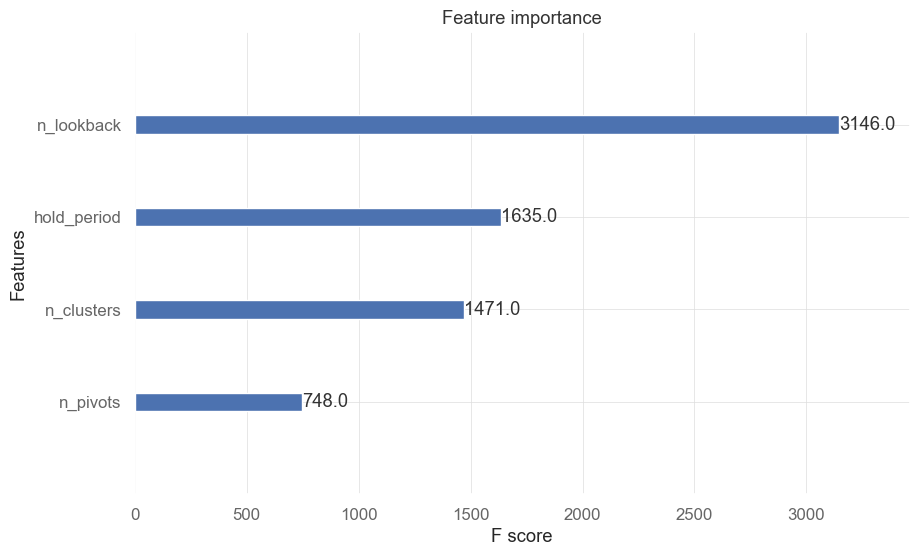

In [12]:
# Feature Importance with XGBoost
import xgboost as xgb

# Separating features and target
X = grid[all_params]
y = grid['score']

# Convert the dataset into an optimized data format called DMatrix
dtrain = xgb.DMatrix(X, label=y)

# Define parameters
params = {
    'max_depth': 3,
    'eta': 0.03,
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse'
}


# Train the model
bst = xgb.train(params, dtrain, num_boost_round=1000)

# Get feature importance
importance = bst.get_score(importance_type='weight')
print("Feature importances:", importance)

# Visualize feature importance
xgb.plot_importance(bst)
plt.show()

In [13]:
x = plot_heatmaps(grid, all_params, 'score')

interactive(children=(Dropdown(description='Parameter 1:', options=('n_pivots', 'n_clusters', 'n_lookback', 'h…

In [14]:
plot_heatmaps_convolve(grid, all_params, 'score')

interactive(children=(Dropdown(description='Parameter 1:', options=('n_pivots', 'n_clusters', 'n_lookback', 'h…

##### CONCLUSION : RANGE OF STABLE PARAMETERS RELATIVE TO N_LOOKBACK
- Stable values for `n_lookback` are 8, 14 and 15. 8 is the most stable value, while 14/15 show greater performances

- `n_lookback` x `n_clusters`
  - 8 : All `n_clusters` values show good performance. Best performances occur at ranges `16 -> 19` and `26 -> 30`
  - 14/15 : `n_clusters = (24 -> 30)` show good performances

- `n_lookback` x `hold_period`
  - 8 : Lower values of `hold_period = (1, 2, 3)` perform better performance
  - 14/15 : `hold_period = (5, 6)` show stable performance

- `n_lookback` x `n_pivots`
  - 8 : any `n_pivots = (3, 4)` performs well.
  - 14/15 : `n_pivots = 2` has the better performance.
  

##### CONCLUSION : RANGE OF STABLE PARAMETERS RELATIVE TO N_CLUSTER

- `n_clusters` x `hold_period`
  - Stable good performance occur at `n_clusters >= 22`, with the best peformances at `hold_period = (6, 7)` and `n_clusters >= (26 -> 30)`

- `n_clusters` x `n_pivots`
  - 22-30 : any `n_pivots` value (3, 4) performs well.  Better results are observed on `n_pivot=4`

##### CONCLUSION : RANGE OF STABLE PARAMETERS RELATIVE TO HOLD_PERIOD

- `hold_period` x `n_pivots`
  - Similar performance across the values of `n_pivots = (3, 4)` 

##### General Trends and Observations:
- Lower n_lookback values tend to have a wider acceptable range for n_clusters and shorter effective hold periods.
- As n_lookback increases, n_clusters and hold_period also increase for better stable performance.
- n_pivots tend to be less sensitive and generally perform well with 3 or 4 across different configurations, with particular configurations optimizing at specific values.

##### Summary:
1. `n_lookback`
  - Most Stable Value: 8
  - Also Stable: 14, 15 (but slightly less stable than 8)

2. `n_clusters`
  - Stable Range (Good Performance): 22 - 30
  - Best Performance Within Range: 26 - 30


3. `hold_period`
  - Stable Range with n_lookback 8: 1 - 3
  - Stable Range with n_lookback 14/15: 5 - 6
  - Stable Range with n_clusters >= 22: 6 - 7

4. `n_pivots`

  - Stable with n_lookback of 8: 3 - 4
  - Stable with n_lookback 14/15: 2
  - Stable with n_cluster 22-30: 3 - 4 (better results with 4)